In [1]:
import pandas as pd
import numpy as np
#np.random.seed(42)

In [2]:
plays = pd.read_csv('user_artists.dat', sep='\t')
artists = pd.read_csv('artists.dat', sep='\t', usecols=['id','name'])

# Merge artist and user pref data
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})

# Group artist by name
artist_rank = ap.groupby(['name']) \
    .agg({'userID' : 'count', 'playCount' : 'sum'}) \
    .rename(columns={"userID" : 'totalUsers', "playCount" : "totalPlays"}) \
    .sort_values(['totalPlays'], ascending=False)

artist_rank['avgPlays'] = artist_rank['totalPlays'] / artist_rank['totalUsers']
print(artist_rank)

                    totalUsers  totalPlays     avgPlays
name                                                   
Britney Spears             522     2393140  4584.559387
Depeche Mode               282     1301308  4614.567376
Lady Gaga                  611     1291387  2113.563011
Christina Aguilera         407     1058405  2600.503686
Paramore                   399      963449  2414.659148
...                        ...         ...          ...
Morris                       1           1     1.000000
Eddie Kendricks              1           1     1.000000
Excess Pressure              1           1     1.000000
My Mine                      1           1     1.000000
A.M. Architect               1           1     1.000000

[17632 rows x 3 columns]


In [3]:
# Merge into ap matrix
ap = ap.join(artist_rank, on="name", how="inner") \
    .sort_values(['playCount'], ascending=False)

# Preprocessing
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
ap = ap.assign(playCountScaled=play_count_scaled)
#print(ap)

# Build a user-artist rating matrix 
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
ratings = ratings_df.fillna(0).values

# Show sparsity
sparsity = float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1]) * 100
print("sparsity: %.2f" % sparsity)


sparsity: 0.28


In [4]:
ap

,id,name,userID,artistID,playCount,totalUsers,totalPlays,avgPlays,playCountScaled
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376,1.000000
35843,792,Thalía,2071,792,324663,26,350035,13462.884615,0.920513
27302,511,U2,1094,511,320725,185,493024,2664.994595,0.909347
8152,203,Blur,1905,203,257978,114,318221,2791.412281,0.731441
26670,498,Paramore,1664,498,227829,399,963449,2414.659148,0.645960
...,...,...,...,...,...,...,...,...,...
38688,913,Destiny's Child,1810,913,1,83,34746,418.626506,0.000000
32955,697,Sia,1290,697,1,56,27597,492.803571,0.000000
71811,4988,Chris Spheeris,510,4988,1,5,3106,621.200000,0.000000
91319,17080,Haylie Duff,1851,17080,1,1,1,1.000000,0.000000


In [5]:
from scipy.sparse import csr_matrix

# Build a sparse matrix
X = csr_matrix(ratings)

n_users, n_items = ratings_df.shape
print("rating matrix shape", ratings_df.shape)

user_ids = ratings_df.index.values
artist_names = ap.sort_values("artistID")["name"].unique()

rating matrix shape (1892, 17632)


In [6]:
seed = 42
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset

# Build data references + train test
Xcoo = X.tocoo()
data = Dataset()
data.fit(np.arange(n_users), np.arange(n_items))
interactions, weights = data.build_interactions(zip(Xcoo.row, Xcoo.col, Xcoo.data)) 
train, test = random_train_test_split(interactions,random_state=np.random.RandomState(seed))


In [7]:
train

<1892x17632 sparse matrix of type '<class 'numpy.int32'>'
	with 73758 stored elements in COOrdinate format>

In [8]:
# Train
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(train, epochs=10, num_threads=2)

In [9]:
# Evaluate
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.37, test 0.13.
AUC: train 0.96, test 0.86.


In [10]:
# Predict
scores = model.predict(0, np.arange(n_items))
top_items = artist_names[np.argsort(-scores)]
print(top_items)

['The Beatles' 'Radiohead' 'Depeche Mode' ... 'The Blues Busters' 'Sizzla'
 'I Wayne']


In [11]:
# Evaluate
def evaluate(model):
   model.fit(train, epochs=10, num_threads=2)
   train_precision = precision_at_k(model, train, k=10).mean()
   test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

   train_auc = auc_score(model, train).mean()
   test_auc = auc_score(model, test, train_interactions=train).mean()

   print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
   print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

   # Predict
   scores = model.predict(0, np.arange(n_items))
   top_items = artist_names[np.argsort(-scores)]
   print(top_items)

In [12]:
def scoring():
    learning_ratelist = [0.05,0.10]
    losslist=['bpr','warp']
    result = []
    
    for elt in learning_ratelist:
        for i in losslist:
               model = LightFM(learning_rate=elt, loss=i)
               model.fit(train, epochs=10, num_threads=2)
               train_precision = precision_at_k(model, train, k=10).mean()
               test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

               train_auc = auc_score(model, train).mean()
               test_auc = auc_score(model, test, train_interactions=train).mean()

               dictmap = ()
               dictmap = {'name' :i,'learning rate' : elt,
                          'train_precision':train_precision,'test_precision':test_precision,
                          'train_auc' : train_auc,'test_auc':test_auc}
            
               result.append(dictmap)
    result = pd.DataFrame(result)       
    return result

In [13]:
scoring()

,name,learning rate,train_precision,test_precision,train_auc,test_auc
0,bpr,0.05,0.362606,0.120502,0.849268,0.781288
1,warp,0.05,0.375212,0.129098,0.965788,0.858590
2,bpr,0.10,0.413771,0.122157,0.913769,0.808196
3,warp,0.10,0.378867,0.124346,0.983737,0.844180


In [14]:
def get_recommendation(model, ratings_df, user_ids):


    n_users, n_items = ratings_df.shape

    for user_id in user_ids:
        scores = model.predict(user_id, np.arange(n_items))
        top_items = artist_names[np.argsort(-scores)]

        print("User %s" % user_id)

        print("     Recommended:")

        for x in top_items[:20]:
            print("        %s" % x)


In [15]:
np.arange(n_items)

array([    0,     1,     2, ..., 17629, 17630, 17631])

In [16]:
ratings_df.shape

(1892, 17632)

In [17]:
ap.shape

(92834, 9)

In [18]:
ap[['name','userID','playCountScaled']].sort_values(['userID','playCountScaled'],ascending=[True,False])

,name,userID,playCountScaled
542,Duran Duran,2,0.039360
653,Morcheeba,2,0.033142
676,Air,2,0.032181
751,Hooverphonic,2,0.029201
769,Kylie Minogue,2,0.025467
...,...,...,...
87884,Moëvöt,2100,0.000785
92821,Les Chants de Nihil,2100,0.000743
68926,ColdWorld,2100,0.000729
80302,Dissimulation,2100,0.000655


In [19]:
get_recommendation(model, ratings_df, [2])

User 2
     Recommended:
        The Beatles
        Radiohead
        Muse
        The Cure
        Depeche Mode
        Coldplay
        Nirvana
        Red Hot Chili Peppers
        Placebo
        The Killers
        Pink Floyd
        Kings of Leon
        Queen
        Metallica
        Oasis
        The Kooks
        Björk
        The Strokes
        Daft Punk
        Arctic Monkeys


In [20]:
def get_ground_truth(user):
    gt = ap[ap['userID']==user][['name','userID','playCountScaled']].sort_values(['playCountScaled'],ascending=False)
    return gt['name']

In [21]:
get_ground_truth(2)

542              Duran Duran
653                Morcheeba
676                      Air
751             Hooverphonic
769            Kylie Minogue
1067               Daft Punk
1218    Thievery Corporation
1237               Goldfrapp
1319               New Order
1426             Matt Bianco
1428               Talk Talk
1453           Prefab Sprout
1456                  Enigma
1497                Röyksopp
1568                Coldplay
1937               Faithless
1956                 Madonna
2385                Icehouse
2402                    Sade
2431                    Moby
2516                    Dido
2573            Depeche Mode
2855            Café Del Mar
2862                   Basia
2863              Camouflage
2895              Electronic
2910          George Michael
2953          The Adventures
2955         Fiction Factory
2956           Groove Armada
2970              Portishead
3077             Marc Almond
3086              Cock Robin
3087                Cut Copy
3128          

In [22]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd_mod=svd.fit(train)
print(svd_mod.explained_variance_ratio_)

print(svd_mod.explained_variance_ratio_.sum())

print(svd_mod.singular_values_)

[0.03013438 0.02108422 0.01236868 0.01135097 0.00813483]
0.08307307
[65.40983  44.692722 29.753304 28.463861 24.156944]


In [23]:
import time
alpha = 1e-05
epochs = 20
num_components = 32


warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(model, test, train_interactions=train).mean())

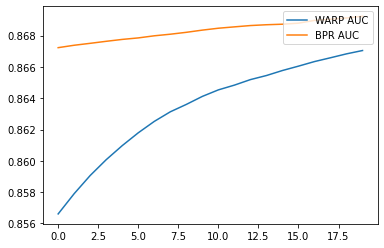

In [24]:
import numpy as np

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

In [25]:
import itertools

import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score


def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = auc_score(model, test, train_interactions=train, num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)


In [26]:
random_search(train, test, num_samples=10, num_threads=1)

<generator object random_search at 0x7fda54871660>

In [27]:
(score, hyperparams, model) = max(random_search(train, test, num_threads=2), key=lambda x: x[0])

In [28]:
print("Best score {} at {}".format(score, hyperparams))

Best score 0.8874611258506775 at {'no_components': 62, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.018658416727541923, 'item_alpha': 1.9462170358049824e-08, 'user_alpha': 2.8758550720577514e-09, 'max_sampled': 6, 'num_epochs': 12}


In [29]:
# Optimisation de paramètres avec GridSearch

from sklearn.model_selection import ParameterGrid# Create the parameter grid based on the results of random search 

param_grid = {
    'learning_rate': [0.05 , 0.08],
    'learning_schedule':['adagrad','adadelta'],
    'loss': ['warp','bpr','logistic','warp-kos']
    
}
# definition liste score auc
auc_score_values = []

for grid in ParameterGrid(param_grid):
    model = LightFM(**grid)
    pred = model.fit(train)
    auc_score_values.append(round(auc_score(model, test, train_interactions=train).mean(),3))
    
max_value = max(auc_score_values) 
max_index = np.argmax(auc_score_values)
ParameterGrid(param_grid)[max_index ].items()

dict_items([('loss', 'warp'), ('learning_schedule', 'adadelta'), ('learning_rate', 0.08)])

In [30]:
list(ParameterGrid(param_grid))

[{'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'warp'},
 {'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'bpr'},
 {'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'logistic'},
 {'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'warp-kos'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'warp'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'bpr'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'logistic'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'warp-kos'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'warp'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'bpr'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'logistic'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'warp-kos'},
 {'learning_rate': 0.08, 'learning_schedule': 'adadelta', 'loss': 'warp'},
 {'learning_

In [31]:
print(f"la combinaison de paramètres qui permet d'optimiser  le model : {round(max_value,3)} est la suivante \n {ParameterGrid(param_grid)[max_index ].items()}")

la combinaison de paramètres qui permet d'optimiser  le model : 0.8199999928474426 est la suivante 
 dict_items([('loss', 'warp'), ('learning_schedule', 'adadelta'), ('learning_rate', 0.08)])
